In [2]:
import pandas as pd
import numpy as np
import datetime as datetime
# import folium
# from folium import Map
# from folium import plugins
# from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from shap import LinearExplainer, summary_plot
import math
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
%matplotlib inline

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('max_columns', None)
pd.set_option('max_columns', None)

from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [ ]:
#Create and clean dataframes
stations = pd.read_csv('austin_bikeshare_stations.csv')
stations['start_station_id'] = stations['station_id']
stations = stations.rename(columns={"station_id": "end_station_id"})

trips = pd.read_csv('austin_bikeshare_trips.csv')
trips = trips[trips['year'] != 2013]
trips['date'] = trips['start_time'].str[:10]
trips['date'] = pd.to_datetime(trips['date'])
trips['weekday'] = trips['date'].dt.day_name()
trips['start_time'] = trips['start_time'].str[-8:]
trips = trips.merge(stations[['start_station_id','latitude']],on='start_station_id', how='left')
trips = trips.rename(columns={"latitude": "start_latitude"})
trips = trips.merge(stations[['start_station_id','longitude']],on='start_station_id', how='left')
trips = trips.rename(columns={"longitude": "start_longitude"})
trips = trips.merge(stations[['end_station_id','latitude']],on='end_station_id', how='left')
trips = trips.rename(columns={"latitude": "end_latitude"})
trips = trips.merge(stations[['end_station_id','longitude']],on='end_station_id', how='left')
trips = trips.rename(columns={"longitude": "end_longitude"})
trips['start_location'] = list(zip(round(trips.start_latitude,5), round(trips.start_longitude,5)))
trips['end_location'] = list(zip(round(trips.end_latitude,5), round(trips.end_longitude,5)))

weather = pd.read_csv('austin_weather.csv')
weather['year'] = pd.DatetimeIndex(weather['Date']).year
weather['month'] = pd.DatetimeIndex(weather['Date']).month
weather['PrecipitationSumInches'] = weather['PrecipitationSumInches'].replace('T',0.01)
weather['Rain'] = weather.Events.str.contains('Rain')
weather['Thunderstorm'] = weather.Events.str.contains('Thunderstorm')
weather['Fog'] = weather.Events.str.contains('Fog')
weather['Snow'] = weather.Events.str.contains('Snow')
weather = weather[weather['year'] != 2013]

crime = pd.read_csv('crime_merged.csv', dtype = object)
crime = crime.drop(columns=['Occurred Date Time', 'Report Date Time'])
crime['year'] = pd.DatetimeIndex(crime['Occurred Date']).year
crime['month'] = pd.DatetimeIndex(crime['Occurred Date']).month
crime['Report Date'] = pd.to_datetime(crime['Report Date'])
crime['weekday'] = crime['Report Date'].dt.day_name()
crime['Latitude'] = crime.Latitude.astype(float)
crime['Longitude'] = crime.Longitude.astype(float)
crime['location'] = list(zip(round(crime.Latitude,5), round(crime.Longitude,5)))
crime = crime[crime['year'].between(2014,2017)]



![Image of Bike](https://res.cloudinary.com/sagacity/image/upload/c_crop,h_1068,w_1600,x_0,y_107/c_limit,dpr_3.0,f_auto,fl_lossy,q_80,w_500/Apart-BikeV2_ndxa2z_bmpazv.jpg)

# MetroBike Austin: Vision for the Future

## _Authors:_ Christian Lee, Joe Niehaus, Jason Petri, Jordan Pflum

### Abstract:
Over the last 5 years “micromobility” companies, defined as companies that operate small, lightweight vehicles such as scooters and bikes that can be rented for short periods of time, have proliferated. The City of Austin operates its own such company, MetroBike, which operates bike stations in dozens of locations around the city. Austin’s enjoyable climate and extensive array of activities makes the city’s shareable bikes popular among local commuters and tourists alike. However, Austin has a very diverse population, that is segregated in many ways to specific areas of town. Moreover, crime is more common in some of these areas than others. Our question is, do these factors, and others, affect the ridership numbers of MetroBike? Do certain stations require more bicycles than others?

In this project, our team seeks to quantify the relationship between crime and ridership for a given station and looks to build upon this by identifying other useful features which may impact the number of rides that origination from any one station. If we are able to identify said features, and those features have a statistically significant impact on ridership at a given station, we hope that our research could help MetroBike better service their stations and ensure that enough bikes are available at a given time. Not only does this lead to a better experience for patrons of the company, but it should also allow the company to operate more efficiently.

### Problem & Importance
As stated, the problem we are addressing is the potentially inefficient management of MetroBike’s ridesharing stations around the city of Austin. This problem was identified through the inspection of several stations around the city where MetroBike’s shareable bicycles sat idle. As each bike is rented for a very short period of time, the use of said bikes represents revenue for the company and in effect the city. Idle bikes represent lost revenue.

But why do these bikes sit idle? Are there characteristics of the surrounding area that prevent commuters and tourists from using the bikes? Is it due to the crime in the area? How much does weather play a role in the rental of the bikes in that area? In other words, are the bikes used to get to work, in which case a cloudy, overcast day is unlikely to play a role in the popularity of a station, or are they used primarily for recreation? Is there a festival, a football game, or some other popular event occurring on that day and in that area?

Each of these questions represents a potential feature that can be added to our data and eventually modeled to understand and hopefully predict the frequency of rides originating at a specific MetroBike station. The importance of this is clear from the initial exploration of the problem. If we can understand the relationship between each of these features and MetroBike’s ridership, we can hopefully predict the ridership on a given day at a given station. If we can successfully do this, MetroBike can expend its resources more efficiently, stocking up certain stations that are likely to be busy, thereby pulling in more revenue than they would if they left bikes in unused locations. This is a common exercise for businesses who rely on the efficient expenditure of resources to facilitate their customers behavior, simultaneously saving money, while potentially bringing in more revenue.


![GPS Map](https://cdn-images-1.medium.com/fit/t/1600/480/1*6u81qSRsAS1Bh8KfzmvKDQ.png)

### Approach and Rationale
After joining the MetroBike datasets, we are looking at three possible pieces of intelligence we can derive from our data. Each of these insights will be found using a regression analysis of our data. To do this, we will join the Bike share, Weather and Crime tables on date.

From this master database, we will seek to run a regression with the goal of determining the most popular stations from which users are likely to initiate a bike share. The station from which a ride was initiated will be our dependent variable and the features such as weather and crime on a given day will be our independent variables.

Clearly, the number of features will need to be whittled down to reduce dimensionality and prevent overfitting. Our reduction of features will likely be done using a mixture of manual reduction of features (i.e. removing features we do not think will play a role in our analysis, or may be redundant across datasets), as well as with lasso feature selection. Prior to conducting the lasso feature selection, we will initialize weights using the sum of squares method. Once we have initialized our weights, we will then penalize the model’s number of features using lasso, hopefully to the point where certain features which have been deemed unimportant will be dropped from our model.

With our dataset in place, and our features narrowed down, we will seek to look at how certain changes in crime and weather impact the likelihood of a rider choosing to redeem a bike share at a certain location. Does an increase in crime in a certain location reduce the likelihood of a rider using bike share? Does the weather play an important role in that location’s popularity (i.e. are there riders who need rides in that location regardless of the weather or is it a location that is only utilized on good weather days)? 

Finally, can our model predict ridership? If so, MetroBike will know when and how completely to replenish their stations with bicycles for the upcoming day's rides. It can also indicate areas that would be prime candidates for new stations given the amount of demand in those locations. 

### Data Collection

The datasets available for our problem are all specific to the City of Austin. We used four datasets total:

#### Crime Data
The largest set contains 18 years of public crime reports from the Austin Police Department. This is a public dataset, available on the [data.texas.gov website](http://data.texas.gov). It is updated on a weekly basis and contains a record of incidents that the Austin Police Department responded to and filed reports on. Though this data is available from 2002 onward, we will be primarily reviewing data from 2013 through 2017, coinciding with the available data from our most limited dataset.

##### Violent Crimes in Austin (2013-2017)
Adjust the slider to pinpoint crimes in a certain month

In [3]:
#Setup HeatMapWithTime data
#HeatMapCrime df
hmc = crime[['Category Description','Occurred Date','Latitude','Longitude']].dropna().copy()
hmc['Occurred Date'] = pd.to_datetime(hmc['Occurred Date'])
hmc['YrMo'] = pd.to_datetime(hmc['Occurred Date']).dt.to_period('M')

######IMPORTANT: Make your crime selections or comment out this section######
crime_select = ['Murder','Robbery','Aggravated Assault'] 
    #choices = 'Murder','Robbery','Aggravated Assault','Auto Theft','Burglary','Theft'
hmc = hmc[hmc['Category Description'].isin(crime_select)]
######IMPORTANT: Make your crime selections or comment out this section######

#Sorted ist of unique month/year combinations in df
date_range = hmc['YrMo'].astype(str).unique()
date_range.sort()
date_range = date_range.tolist()

#Create list of lists, sorted by unique month/year
heat_data = [[[row['Latitude'],row['Longitude']] for index, row in hmc[hmc['YrMo'] == i]
              .iterrows()] for i in date_range]

#Folium HeatMapWithTime
from folium import plugins
timemap = Map(location=[30.3, -97.73], zoom_start=11)

#Mapping
map_data = plugins.HeatMapWithTime(heat_data,index=date_range,radius=15,min_opacity=.3,max_opacity=.5,
                                   use_local_extrema=True,min_speed=1,max_speed=5,speed_step=1,auto_play=True)
map_data.add_to(timemap)
#Display the Map
timemap

#### Weather Data
We will be joining the Crime dataset with publicly available weather data, obtained from [Weather Underground](http://wunderground.com), and collected from the Austin KATT Station (located at Camp Mabry in West-Central Austin). This data primarily includes historical temperature, precipitation, humidity, and wind speed for the City of Austin and local suburbs.

The data needs some cleaning, as you’d expect. The file has several quirks we need to clean up:

 - Some precipitation values are listed as ‘T’, meaning trace. This is a very small amount of rain, but not enough to register a value in inches. We replaced these with a value of 0.01 inches, so the entire column is numeric.

 - The events column is a string with a concatenation of ‘Fog’, ‘Rain’, 'Snow', and ‘Thunderstorm’, depending on which conditions were present. Here we created three new boolean columns which are set to True if there was Fog, Rain, Snow or Thunderstorms on that day.

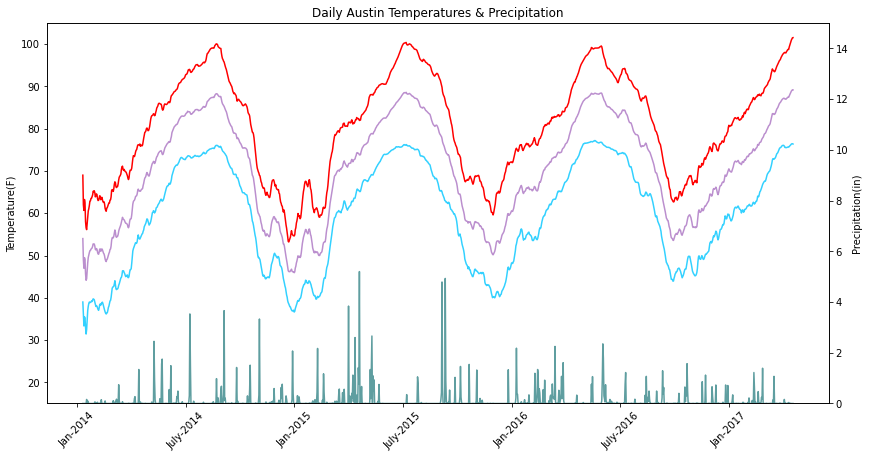

In [4]:
#df for plot
temps = weather[['Date','TempHighF', 'TempAvgF', 'TempLowF','PrecipitationSumInches']].copy()

#Smoothing temperatures for plot
temps['High'] = temps.TempHighF.rolling(30, min_periods=1).mean()
temps['Avg'] = temps.TempAvgF.rolling(30, min_periods=1).mean()
temps['Low'] = temps.TempLowF.rolling(30, min_periods=1).mean()
temps['PrecipitationSumInches']=temps['PrecipitationSumInches'].astype(float)

#Austin Weather & Precipitation Plot
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.plot(temps['High'],color='#FF0000')
ax1.plot(temps['Avg'],color='#BB8FCE')
ax1.plot(temps['Low'],color='#33D1FF')
ax1.set_ylim([15,105])

ax1.set_xticklabels(['0','Jan-2014','July-2014','Jan-2015','July-2015','Jan-2016','July-2016','Jan-2017','July-2017'])
plt.xticks(rotation=45)
plt.ylabel('Temperature(F)')

ax2 = ax1.twinx() 
ax2.plot(temps['PrecipitationSumInches'],color='cadetblue')
ax2.set_ylim([0,15])

plt.title('Daily Austin Temperatures & Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation(in)')
plt.show()

#### Bike Trip Datasets
Finally, we will be measuring our publicly available data against information on nearly 650,000 Bike Share Trips within the city, made available by the City of Austin for trips from 2013 through 2017. The original dataset is available from [Google Public Data](https://www.google.com/publicdata/directory).  Bike shares are a service offered by a handful of providers (the most prolific in Austin being Austin B-Cycle) and are becoming a popular alternative means of transportation. 

This data includes information on bike trip start location, stop location, duration and type of bike share user. An additional dataset includes bike station location data by latitude and longitude, as well as location operating status. We joined these tables on the individual station ID in order to capture latitude and longitude data for each ride. 

Hover over a station to see it's location:

In [5]:
locations = stations[['latitude', 'longitude']]
locationlist = locations.values.tolist()
names = stations['name'].tolist()

stationmap = Map(location=[30.269, -97.74],tiles="stamentoner",zoom_start=14)
for point in range(0, len(locationlist)):
    folium.Marker(location=locationlist[point], popup="Station",tooltip=names[point]).add_to(stationmap)
    
stationmap

### Pre-Processing

Detrending
- A major concern when working with time series data is controlling for non-stationary data. Because our goal is to accurately model the evolution of a time series (in the case bike ridership) with respect to other observable features, we need to remove any change in the mean of the data over time. Detrending bike ridership will allow us to more accurately identify subtrends in the time series and more accurately identify which factors influence ridership the greatest.

- To detrend the data, we fit a linear regression to the data and recorded the constant and slope of the line as well as their respective t-statistics. Because the t-statistic for ridership growth was significantly different from 0 (t-stat = 6.392) with a value of 0.1824. This means that on average ridership increased per day by 0.1824 rides. Since we determined there was a significant trend in ridership we proceeded to detrend the data by subtracting out the cumulative trend from every data point. The results are shown below:


In [4]:
# Read in and format data
trips = pd.read_csv('austin_bikeshare_trips.csv')
trips['start_time'] = pd.to_datetime(trips['start_time'], format='%Y-%m-%d %H:%M:%S')

# Add Day Period
trips['start_time'] = pd.to_datetime(trips['start_time'], format='%Y-%m-%d %H:%M:%S')
trips['Start Time (Day)'] = trips['start_time'].dt.to_period('D')

# Count number of rides per day
bikesRides = trips.groupby(['Start Time (Day)']).count()['bikeid']

Y = bikesRides.values
X = list(range(len(Y)))
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
print_model = model.summary()
print(print_model)

# Constant
constant = model.params[0]

# Beta
trend = model.params[1]

# Trend Line
trendOnly = trend * np.array(range(len(Y)))
trendLine = (trend * np.array(range(len(Y))))+constant
constantLine = constant + np.zeros(len(Y))

bikesRides = bikesRides.reset_index()
bikesRides = bikesRides.rename(columns={'bikeid': 'Number of Rides'})
bikesRides['trend'] = trendOnly
bikesRides['trendLine'] = trendLine
bikesRides['Constant Line'] = constantLine

bikesRides['Detrended Data'] = bikesRides['Number of Rides'] - bikesRides['trend']
bikesRides = bikesRides.set_index(['Start Time (Day)'])
bikesRides = bikesRides.to_timestamp()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     40.86
Date:                Fri, 11 Dec 2020   Prob (F-statistic):           2.31e-10
Time:                        22:01:57   Log-Likelihood:                -9206.4
No. Observations:                1257   AIC:                         1.842e+04
Df Residuals:                    1255   BIC:                         1.843e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        401.3402     20.703     19.386      0.0

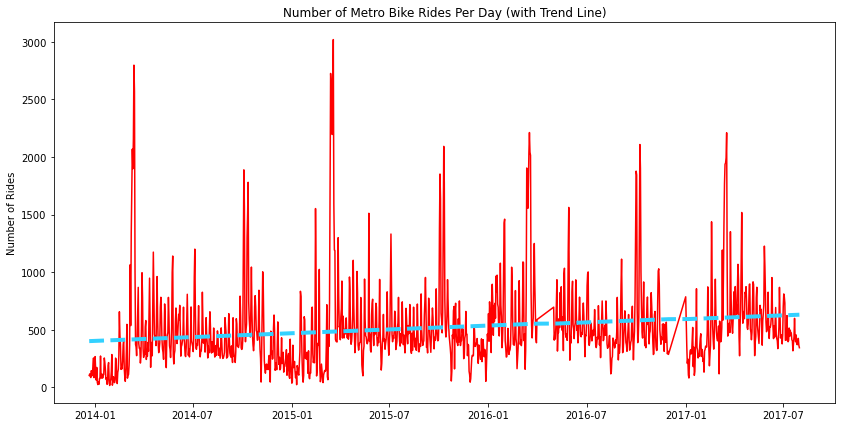

In [14]:
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.plot(bikesRides['Number of Rides'],color='#FF0000')
ax1.plot(bikesRides['trendLine'],color='#33D1FF', linewidth=4.0, ls='dashed')

plt.ylabel('Number of Rides')
plt.title('Number of Metro Bike Rides Per Day (with Trend Line)')
plt.show()

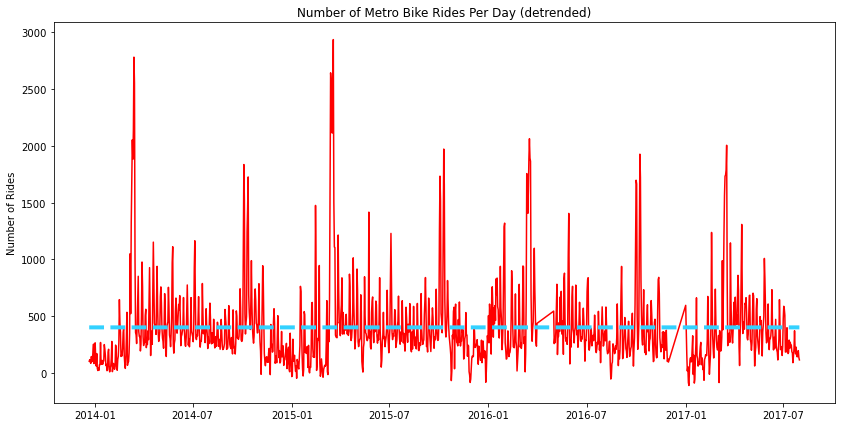

In [15]:
fig, ax1 = plt.subplots(figsize=(14,7))
ax1.plot(bikesRides['Detrended Data'],color='#FF0000')
ax1.plot(bikesRides['Constant Line'],color='#33D1FF', linewidth=4.0, ls='dashed')

plt.ylabel('Number of Rides')
plt.title('Number of Metro Bike Rides Per Day (detrended)')
plt.show()

### Feature Engineering & Exploration
  
##### Weather
 - We lagged each of the following features back one day to avoid forward looking in our prediction. Additionally, we took rolling moving averages of each of the features in 1 day, 3 day, 1 week and 1 month windows.
  - Average Sea Level Pressure in Inches
  - Average Wind Pressure
  - Average Visibility in Miles
  - Average Dew Point
  - Average Temperature in Farenheit
  - Sum of Precipitation in Inches
  - Notable Weather Events
 - This gave us a total of 28 weather features.

##### Events
 - ACL, SXSW, UT Home Footbal Games, Major US Holidays
  - Just as ridership varies by weekday/weekend, we expect these events to correspond to higher average rides
  


##### Crime
 - We want to quantity crimes affecting MetroBikes. We would assume the distance of the crime from a station would play a role in ridership to or from that station (ie a station with a lot of crime nearby would have lower ridership than an equivalent station without a lot of crime around it). 
  - We varied the distance a crime had to be from a metro bike station in order to be considered by 50m, 100m, 250m, 500m. 


 - Additionally, we assumed that as time passed, people would gradually begin to forget about the crime. Said a different way, people’s memory is finite and has a window of remembering. To account for this, we varied the window to count a crime occurring around a station, and summed all valid crimes that fit the criteria pairs laid out above for every day. 
 
 
 - For example, on 01/01/2014, we quantify crime affecting metro bikes with the following features:
  - Sum crime within 50m, 100m, 250m, 500m of any given station in the past 1 day, 3 days, 1 week, 1 month.
  
  - The map below displays the stations with a 500m radius drawn them. Any crime occuring within this circle would be counted as effecting Metro Bikes for the relevent crime features.

In [76]:
locations = stations[['latitude', 'longitude']]
locationlist = locations.values.tolist()
stationmap = Map(location=[30.2672, -97.7431],zoom_start=14)
for point in range(0, len(locationlist)):
    folium.Circle(location=locationlist[point],popup=stations['name'][point],
                  radius=10,color='crimson',fill=True,fill_color='white').add_to(stationmap)
for point in range(0, len(locationlist)):
    folium.Circle(location=locationlist[point],popup=stations['name'][point],
                  radius=250,color='crimson',fill=True,fill_color='white').add_to(stationmap)
stationmap

##### Ridership
 - Using data on past ridership, we pulled in the average number of rides in the past 1 day, 3 days, 1 Week, and 1 Month, as well as the average duration of rides in the same periods.

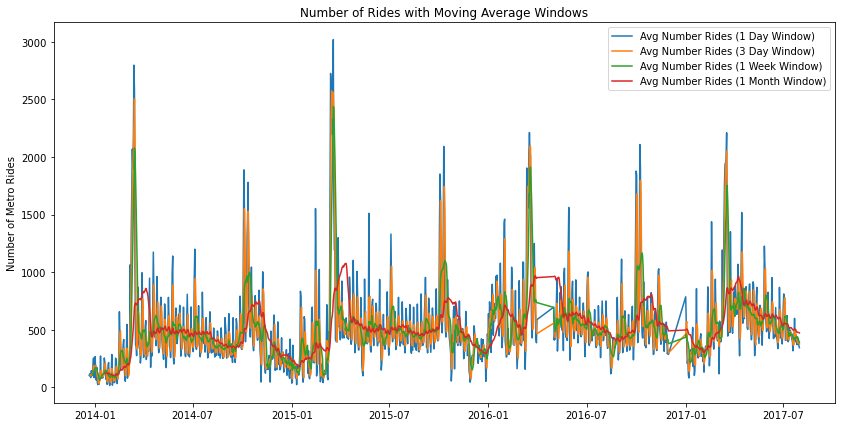

In [52]:
result = pd.DataFrame()
result['Avg Number Rides (1 Day Window)'] = trips.groupby(['Start Time (Day)']).count()['bikeid']
result['Avg Number Rides (3 Day Window)'] = trips.groupby(['Start Time (Day)']).count()['bikeid'].rolling(3).mean()
result['Avg Number Rides (1 Week Window)'] = trips.groupby(['Start Time (Day)']).count()['bikeid'].rolling(7).mean()
result['Avg Number Rides (1 Month Window)'] = trips.groupby(['Start Time (Day)']).count()['bikeid'].rolling(31).mean()

result = result.to_timestamp()

fig, ax = plt.subplots(figsize=(14,7))
for i, col in enumerate(result.columns):
    ax.plot(result[col], label=col)

plt.ylabel('Number of Metro Rides')
plt.title('Number of Rides with Moving Average Windows')
ax.legend()
plt.show()

Below are the frequency of rides per day.
<img src="image (3).png">

##### Time
 - Month of the Year
  - The month helps to capture some seasonal weather patterns, as well as people's behaviors. For example, the average non-commuter is more likely to bike in the spring and summer months than the winter months.
 

In [5]:
trips['month'] = pd.DatetimeIndex(trips['start_time']).month

monthDict = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}


trips['month'] = trips['month'].map(monthDict)



trips['year'] = pd.DatetimeIndex(trips['start_time']).year

df = trips[['year', 'month', 'trip_id']].groupby(['year', 'month']).count()
df = df.reset_index()
df['month'] = pd.Categorical(df['month'], 
                      categories=["Jan",
                                  "Feb",
                                  "Mar",
                                  "Apr",
                                  "May",
                                  "Jun",
                                  "Jul",
                                  "Aug",
                                  "Sep",
                                  "Oct",
                                  "Nov",
                                  "Dec"
                                 ],
                      ordered=True)
df.sort_values(['year', 'month'], inplace=True)
fig = px.line_polar(df, r="trip_id", theta="month", color="year", line_close=True,
                    color_discrete_sequence=['red', 'yellow', 'green', 'blue', 'pink'],
                    template="plotly_dark",
                    title='Ridership (Time of Year - Month)'
                   )
fig.show()

   - Week of the Year
  - Although we have accounted for major events in Austin that would increase ridership, we will inevitably miss some. Because many events are seasonal and occur roughly the same time every year, mapping each week (0,1,2..51) may account for that. This may also account for recurring events in the university calendar, such as Spring, Summer and Winter Breaks. 

In [6]:
# Week Plot
trips['week'] = pd.DatetimeIndex(trips['start_time']).week*(360/52)

df = trips[['year', 'week', 'trip_id']].groupby(['year', 'week']).count()
df = df.reset_index()

fig = px.line_polar(df, r="trip_id", theta="week", color="year", line_close=True,
                    color_discrete_sequence=['red', 'yellow', 'green', 'blue', 'pink'],
                    template="plotly_dark",
                    title='Ridership (Time of Year- Week)',
                    labels = []
                   )
fig.show()

   - Day of the Week
  - There is a clear increase in ridership on the weekends, as we could expect. Mapping each date to its weekday allows us to train the model to understand this imbalance.

In [29]:
# Time of Day Plot
trips['day'] = pd.DatetimeIndex(trips['start_time']).dayofweek

timeDict = {
    0: 'Mon',
    1: 'Tues',
    2: 'Wend',
    3: 'Thur',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}


trips['day'] = trips['day'].map(timeDict)

df = trips[['year', 'day', 'trip_id']].groupby(['year', 'day']).count()
df = df.reset_index()

df['day'] = pd.Categorical(df['day'], 
                      categories=['Mon',
                                  'Tues',
                                  'Wend',
                                  'Thur',
                                  'Fri',
                                  'Sat',
                                  'Sun'
                                 ],
                      ordered=True)
df.sort_values(['year', 'day'], inplace=True)


fig = px.line_polar(df, r="trip_id", theta="day", color="year", line_close=True,
                    color_discrete_sequence=['red', 'yellow', 'green', 'blue', 'pink'],
                    template="plotly_dark",
                    title='Ridership (Day of Week)'
                   )
fig.show()

![ACL](https://forever.travel-assets.com/flex/flexmanager/images/2020/02/14/Austin_-_Austin_City_Limits.jpg)

### Learning and Modeling



#### Feature Selection (LASSO And Ridge Regression)

#### Neural Network
Chosen models and why
training methods

Examples - J&J to confirm

 - Base model: Before starting any of our machine learning models, we will establish a baseline. This gives us a benchmark of performance to compare our model against.

 - Time-based regression: We’ll use a linear model to predict the rentals based on the month of the year, day of the month, day of the week, and hour of day.

 - Daily weather and time-based regression: We’ll take the time-based model, and combine this with the daily weather conditions. We hypothesize that the number of rentals will change alongisde weather conditions.

 - Feature selection: Once we have all our features, we’ll verify which ones are most impactful to our model.

 - Hyperparameter tuning: We’ll look at both Ridge and Lasso models, which use regularization to help us generalize our model to new data.

##### Feature DF

In [65]:
df = pd.read_csv('output_new_detrended.csv')

df = df.drop(columns=['PrecipitationSumInchesAvg_1DayWindow', 'PrecipitationSumInchesAvg_3DayWindow', 'PrecipitationSumInchesAvg_1WeekWindow', 'PrecipitationSumInchesAvg_1MonthWindow'])
df = df.dropna()
df = df.set_index('0')
y = df['totalRides']
X = df.drop(columns=['totalRides'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

#### Baseline Model (Full MLR Model)

The test root mean squared error is 213.02
The training root mean squared error is 166.01


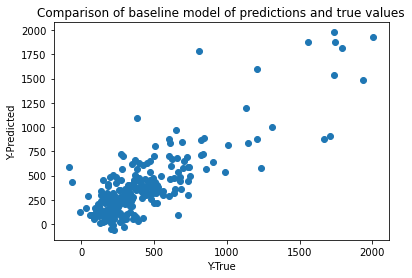

In [63]:
scaler = MinMaxScaler()
scaler.fit(X=X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

reg = LinearRegression().fit(X_train_scaled, y_train)

print(f'The test root mean squared error is {round(math.sqrt(mean_squared_error(reg.predict(X_test_scaled), y_test)), 2)}')
print(f'The training root mean squared error is {round(math.sqrt(mean_squared_error(reg.predict(X_train_scaled), y_train)), 2)}')

result = pd.DataFrame()
result['true'] = y_test
result['predicted'] = reg.predict(X_test_scaled)
plt.scatter(result['true'], result['predicted'])
plt.xlabel('Y-True')
plt.ylabel('Y-Predicted')
plt.title('Comparison of baseline model of predictions and true values')
plt.show()

Above, we see that there is some deviation from a perfect regression. On average, we are off by 213 rides per day in the testing set. In the training set, we can see that the error is much lower at 166 rides. This leads to the suspicion that we may have overfitted the training data. Later, attempts are made to create a more sparse model with fewer features

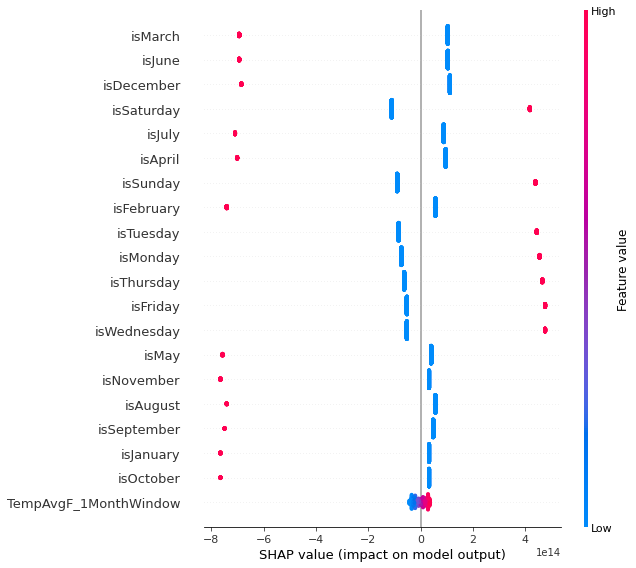

In [64]:
explainer = LinearExplainer(reg, X_train_scaled)
shap_values = explainer.shap_values(X_train_scaled)
summary_plot(shap_values, X_train_scaled, list(X.columns), title='Impact of features on ridership')

It is worth showing the impact on model output for the features at this baseline model stage. As fewer features are dropped out, the relevant features will change. Currently, the categorical feature dictating whether or not the ride is in March has tremendous model impact.

#### Feature Selection

##### LASSO

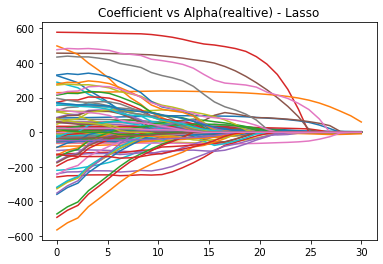

In [68]:
alphas = 10**np.linspace(-2,10,100)*0.5

weights = pd.DataFrame(index=X_train.columns)

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=50, max_iter=100000)
    lasso.fit(X_train, y_train)
    weights[alpha] = lasso.coef_

alphas = np.linspace(0,30,30)
for index, feature in enumerate(weights.index):
    plt.plot(alphas, weights.iloc[index, :30])
    
plt.title('Coefficient vs Alpha(realtive) - Lasso')
plt.show()

In [71]:
n_folds=5
k_fold = KFold(n_folds)

lasso_cv = LassoCV(alphas=alphas, cv=k_fold, max_iter=100000, copy_X=True, normalize=True, random_state=42)
lasso_cv.fit(X_train, y_train)
print("The best value of alpha is {}".format(lasso_cv.alpha_))

lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=100000, copy_X=True, normalize=True, random_state=42)
lasso.fit(X_train, y_train)
# Training
pred_train_lasso = lasso.predict(X_train)
print("The RMSE score associated with the best alpha (for training) is {}".format(np.sqrt(mean_squared_error(y_train, pred_train_lasso))))

# Test
pred_test_lasso = lasso.predict(X_test)
print("The RMSE score associated with the best alpha (for testing) is {}".format(np.sqrt(mean_squared_error(y_test, pred_test_lasso))))

The best value of alpha is 1.0344827586206897
The RMSE score associated with the best alpha (for training) is 201.29316141404834
The RMSE score associated with the best alpha (for testing) is 186.89505776276698


Lasso regrssion resulted in a RMSE for training set of 201 and the testing set of 186. At an alpha of 1.0344 Lasso eliminated all but 8 of the features. These features, their feature type, and weight (ranked in importance) were ACL (Bool) [336.70], South by South West (Bool) [266.15], Week 11 (Bool) [210.73], Saturday (Bool) [194.49], Fiday (Bool) [48.00], March (Bool) [18.59], Average Rides 1-Day Lag (numeric) [0.59], crime 1-Day Lag 500m radius (numeric) [0.22]. 

##### Ridge Regression

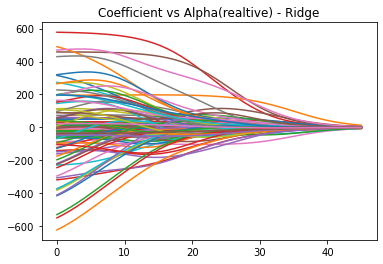

In [73]:
alphas = 10**np.linspace(-2,10,100)*0.5

weights = pd.DataFrame(index=X_train.columns)

for alpha in alphas:
    ridge = Ridge(alpha=alpha, random_state=50, max_iter=100000)
    ridge.fit(X_train, y_train)
    weights[alpha] = ridge.coef_

alphas = np.linspace(0,45,45)
for index, feature in enumerate(weights.index):
    plt.plot(alphas, weights.iloc[index, :45])
    
plt.title('Coefficient vs Alpha(realtive) - Ridge')
plt.show()

In [75]:
n_folds=5
k_fold = KFold(n_folds)

ridge_cv = RidgeCV(alphas=alphas, cv=k_fold)
ridge_cv.fit(X_train, y_train)
print("The best value of alpha is {}".format(ridge_cv.alpha_))

ridge = Ridge(alpha=ridge_cv.alpha_)
ridge.fit(X_train, y_train)

# Training
pred_train_ridge = ridge.predict(X_train)
print("The RMSE score associated with the best alpha (for training) is {}".format(np.sqrt(mean_squared_error(y_train, pred_train_ridge))))

# Test
pred_test_ridge = ridge.predict(X_test)
print("The RMSE score associated with the best alpha (for testing) is {}".format(np.sqrt(mean_squared_error(y_test, pred_test_ridge))))

The best value of alpha is 45.0
The RMSE score associated with the best alpha (for training) is 187.5055411932729
The RMSE score associated with the best alpha (for testing) is 197.9214544315465


Ridge regrssion resulted in a RMSE for training set of 187.50 and the testing set of 197.92. At an alpha of 45.0 Ridge ranked all the features in importance. The top 8 of these features, their feature type, and weight (ranked in importance) were Saturday (Bool) [199.06], Week 11 (Bool) [73.96], South by South West (Bool) [62.53], is March (Bool) [62.22], ACL (Bool) [47.88], whether a Weather Event Occured (Bool) [34.43], is Friday (Bool) [34.00], is week 40 (numeric) [26.00].

#### Neural Network

Using a neural network was attempted using all features, the top features from lasso regressions, and a wide variety of hyper parameters including batch sizes, number of epochs, learning rates, decay rates, quantity of layers, nodes on each layer, and including dropout layers. The iteration of models was conducted in a methodical manner. Models were tweaked into progressively better models through the process of changing the hyper parameters. 

<img src="NeuralNetworkTrainingAll.png">

This image above shows the training and testing loss throughout epochs for the training of the models.

<img src="NeuralNetworkTrainingValidation.png">

This image above shows the testing squared error throughout the epochs. There were a couple of model hyperparameters that resulted in lower squared errors, effectively getting the model out of local minima. The most significant tweaks were the learning rates.

<img src="NeuralNetworkPrediction.png">

The best neural network had a mean squared error, on the test set, of 182 bikes. On the training set, the mean squared error was 174. These results were significantly worse than simple lasso or ridge regressions.

The neural network was retrained on just the non-zero features provided by the lasso regression, and this did not lead to any further improvement.

### Results

After attempting multiple linear regression across all features, we established a baseline model that had, on average, around 213 unexplained trips per day. When observing the on average number of bike trips per day of 538, our loss is adequate for the complex problem that this could be. Most of our loss is atributed to the abnormally high ridership days. We expected that the features we gathered, such as whether or not the day had an event, to account for these days. It seems that our models were meet these expectations.

After detrending data, our model losses significantly improved. This was an aspect of analysis that was worthwile.

Lasso regressions outperformed any other models by not only lowering loss, but defining a sparse model with an optimally-low amount of features. Surprisingly, lasso outperformed neural networks that included interaction between variables and non-linear activations. If there was more analysis to follow, new features could be introduced that would capture the outlier days.

### Conclusions
#### Future Considerations
By using weather data reported hourly instead of daily, we can use the conditions in a more fine-grained way. This could distinguish between cases where it rained in the morning and cleared up in the afternoon, compared to raining all day.

### References


#### Weather Underground

WeatherUnderground - Austin KATT Station

https://www.wunderground.com/?cm_ven=cgi
The dataset above originates from an IBM company called Weather Underground. As described above, this specific dataset will include historical weather data for the Austin, Texas area. Coupled with our other crime-based datasets, we may be able to discover insight for the relationship between crime and weather patterns in the Austin area.

#### MetroBike

MetroBike - Austin B-Cycle Stations

https://austin.bcycle.com/stations
The MetroBike dataset includes geolocation data for the metropolitan bike sharing initiative. These data could provide insight to typical traffic patterns and traveling preferences around the city.

#### Austin Crime

https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu/

City of Austin Crime Reports
The City of Austin provides a data portal to obtain records of incidents received by the Austin Police Department. This public safety dataset provides current data that is updated weekly.

#### Linear Relationships and Weather Patterns

https://nycdatascience.com/blog/r/using/

Using Linear Regression to Predict Weather Patterns
The article above employs linear regression to quantify the trends of weather patterns. Their research concludes that linear regression is a nonlinear system. This understanding will have implications for model selection and pre-training feature modifications.


### Relevant Project Links

https://github.com/jptree/UTMSBA-APM-FINAL


In [52]:
!jupyter nbconvert blog.ipynb --no-input --no-prompt

[NbConvertApp] Converting notebook blog.ipynb to html
[NbConvertApp] Writing 955317 bytes to blog.html
